# Influencia del alcoholismo en los adolescentes en su rendimiento académico

Este proyecto de aprendizaje automático se basa en un conjunto de datos que proporciona una visión detallada de los factores socioeducativos que influyen en el comportamiento de los estudiantes, con un enfoque particular en el consumo de alcohol y el rendimiento académico. Los datos, recopilados a través de una encuesta realizada entre estudiantes de secundaria, ofrecen una oportunidad única para explorar la interacción entre el comportamiento social, el consumo de alcohol y el rendimiento académico.

## Problema a Resolver

El objetivo principal de este proyecto es desarrollar un modelo de aprendizaje automático que pueda predecir el rendimiento académico de los estudiantes en función de una serie de características socioeducativas y de comportamiento. En particular, estamos interesados en entender cómo el consumo de alcohol puede afectar el rendimiento académico de los estudiantes. Este conocimiento podría ser invaluable para los educadores y los responsables de las políticas educativas para desarrollar intervenciones más efectivas y políticas de apoyo para los estudiantes.

## Explicación del Conjunto de Datos

El conjunto de datos consta de varias características que describen el entorno socioeducativo y el comportamiento de los estudiantes. Estas características incluyen información demográfica (como el sexo y la edad del estudiante), información sobre el entorno familiar y escolar (como el tamaño de la familia, el estado de convivencia de los padres, el tiempo de viaje a la escuela), información sobre el comportamiento del estudiante (como el tiempo de estudio, las actividades extraescolares, el consumo de alcohol) y las calificaciones académicas. 

Las calificaciones académicas se proporcionan para dos semestres ('G1' y 'G2'), y también se calcula una calificación media de estos dos semestres ('Media_G1_G2'). Además, se proporciona una calificación categórica ('Calificacion') que indica si el estudiante ha aprobado o no, basándose en la media del curso. Estos dos últimos atributos no son del dataset original, si no que son añadidos que emplearemos para afrontar los distintos modelos.

Detalles de atributos:

    1. Escuela: Escuela del estudiante (binario: GP (Gabriel Pereira) o MS (Mousinho da Silveira))

    2. Sexo: Sexo del estudiante (binario: 'F' - femenino o 'M' - masculino)

    3. Edad: Edad del estudiante (numérica: 15 a 22)

    4. Dirección: Tipo de dirección residencial del estudiante (binario: 'U' - urbano o 'R' - rural)

    5. Famsize: Tamaño de la familia (binario: 'LE3' - menor o igual a 3 o 'GT3' - mayor que 3)

    6. Estado: Padres' estado de convivencia (binario: 'T' - viviendo juntos o 'A' - separados)

    7. Medu: Nivel educativo de la madre (0 - ninguno, 1 - Primaria 1, 2 - Primaria 2, 3 - Secundaria o 4 - Educación Superior)

    8. Fedu: Nivel educativo del padre (0 - ninguno, 1 - Primaria 1, 2 - Primaria 2, 3 - Secundaria o 4 - Educación Superior)

    9. Mjob:Trabajo de la madre (nominal: maestra, salud, servicios, en_casa u Otro)

    10. Fjob:Trabajo del padre (nominal: maestro, salud, servicios, en_casa u Otro)

    11. Razón: Razón para elegir esta escuela (nominal: hogar, reputación, curso u otro)

    12. Tutor:Tutor del estudiante (nominal: madre, padre u otro)

    13. Tiempo de viaje: Tiempo de viaje desde casa a la escuela (intervalos de tiempo: 1 - <15 min., 2 - 15 a 30 min., 3 - 30 min. a 1 hora o 4 - >1 hora)

    14. Tiempo de estudio: Tiempo de estudio semanal (intervalos de tiempo: 1 - <2 horas, 2 - 2 a 5 horas, 3 - 5 a 10 horas o 4 - >10 horas )

    15. Schoolsup: Apoyo educativo adicional (binario: sí o no)

    16. Famsup:Apoyo educativo familiar (binario: sí o no)

    17. Pagadas:Clases privadas sobre temas relacionados con el curso (binario: sí o no)

    18. Actividades: Realiza actividades extraescolares (binario: sí o no)

    19. Guardería: Asistió a guardería (binario: sí o no)

    20. Mayor:Deseo de obtener una carrera (binario: sí o no)

    21. Internet: Acceso a Internet en casa (binario: sí o no)

    22. Romántico: ¿Estás en una relación romántica (binario: sí o no)

    23. Famrel: Calidad de las relaciones familiares (categóricas: de 1 - muy mala a 5 - excelente)

    24. Tiempo libre:Tiempo libre después de la escuela (categórico: de 1 - muy bajo a 5 - muy alto)

    25. Salida: Tiempo con amigos (categórico: de 1 - muy bajo a 5 - muy alto)

    26. Dalc: Consumo de alcohol en la jornada laboral (categórico: de 1 - muy bajo a 5 - muy alto)

    27. Walc: Consumo de alcohol durante el fin de semana (categórico: de 1 - muy bajo a 5 - muy alto)

    28. Salud: Estado de salud actual (categórico: de 1 - muy malo a 5 - muy bueno)

    29. Ausencias: Número de ausencias escolares (numérico: de 0 a 93)

    30. G1:Calificación del primer semestre (numérica: de 0 a 20)

    31. G2:Calificación del segundo semestre (numérica: de 0 a 20)

El atributo school diferencia únicamente entre 2 institutos de EEUU, lo cual no aporta informacion relevante por lo cual se descarta de los conjuntos usados para los modelos. Una vez impresos los pesos de los modelos se observo que este atributo era practicamente el único a traves del cual el modelo evaluava, por lo cual estaba creando un fuerte sesgo. Este es el principal motivo por el cual se ha decidido eliminar, ademas del resto de motivos mencionados.

In [684]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import confusion_matrix

import warnings

warnings.filterwarnings("ignore")

In [685]:
# Definimos una función para asignar las categorías
def asignar_categoria(media):
    if media < 10:
        return "suspenso"
    else:
        return "aprobado"

In [686]:
def conteo_clases(df):
    # Contamos el número de 'aprobados' y 'suspensos'
    num_aprobados = sum(df['Calificacion'] == 'aprobado')
    num_suspensos = sum(df['Calificacion'] == 'suspenso')

    # Etiquetas para el eje x
    labels = [f'Aprobados {num_aprobados}', f'Suspensos {num_suspensos}']

    # Valores (número de 'aprobados' y 'suspensos')
    values = [num_aprobados, num_suspensos]

    # Crear el gráfico de barras
    plt.bar(labels, values, color=['green', 'red'])

    # Añadir títulos y etiquetas
    plt.title('Distribución de las calificaciones')
    plt.xlabel('Calificación')
    plt.ylabel('Número de estudiantes')

    # Mostrar el gráfico
    plt.show()

# Procesamiento del Conjunto de Datos y Ajustes Iniciales

Comenzamos leyendo los datos de nuestro conjunto de datos. Posteriormente, eliminamos los atributos ‘school’ y ‘paid’. La razón de esta eliminación es que ‘paid’ es un atributo duplicado en nuestro conjunto de datos y ‘school’ es un atributo que solo contiene dos nombres de institutos. Tras analizar los resultados de los modelos y los datos, concluimos que ‘school’ sesgaba significativamente los modelos, ya que era prácticamente el único atributo que se comprobaba.

A continuación, añadimos las columnas ‘Media_G1_G2’ y ‘Calificacion’, que utilizaremos para dos propósitos distintos. Nuestro modelo se basa en verificar si los estudiantes tendrán dificultades para pasar el curso debido a problemas de alcoholismo. Para ello, intentamos predecir sus notas del primer semestre ‘G1’ y del segundo ‘G2’. Sin embargo, para una mayor generalización de si pasarán el curso o no, optamos por calcular la nota media de los semestres y utilizar este atributo como objetivo para nuestra predicción. Por otro lado, el atributo ‘Calificacion’ es una etiqueta que indica si el estudiante ha aprobado o no, basándose en la media del curso calculada previamente. Este será nuestro objetivo para los modelos de clasificación.

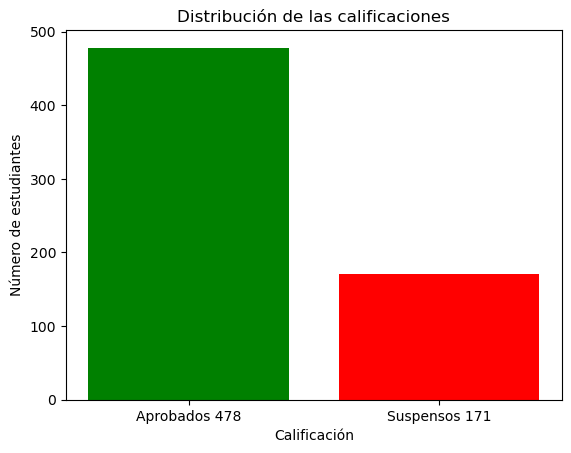

In [687]:
# Lee el archivo CSV
df = pd.read_csv('student.csv')

# Eliminamos las columnas 'school' y 'paid'
df = df.drop(['school'], axis=1)

# Calculamos la media de las columnas G1 y G2
df['Media_G1_G2'] = df[['G1', 'G2']].mean(axis=1)

# Aplicamos la función a la nueva columna para crear la columna de categorías
df['Calificacion'] = df['Media_G1_G2'].apply(asignar_categoria)

conteo_clases(df)

# Con esta función seleccionamos los atributos categóricos y los transformamos a codificación one-hot
categorical_columns = df.select_dtypes(include=['object']).columns
for i in categorical_columns:
    if len(df[i].unique()) == 2:
        # Si solo hay dos categorías, usar LabelEncoder
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    else:
        df_dummies = pd.get_dummies(df[i], prefix=i)
        df = pd.concat([df.drop(i, axis=1), df_dummies],axis=1)
df['Media_G1_G2'] = df['Media_G1_G2'].astype(int)

Test_names = df.columns.tolist()

# Eliminamos las columnas especificadas de la lista
for column in ['G1', 'G2', 'Media_G1_G2', 'Calificacion']:
    Test_names.remove(column)

Observamos una gran parte de los datos son aprobados frente a unos pocos suspensos. Por lo que aplicaremos la técnica Random Under Sampling para tener un mejor balanceo de datos.

In [688]:
# Supongamos que 'target' es tu variable objetivo
target_counts = df['Calificacion'].value_counts()

# Encuentra la clase minoritaria y mayoritaria
minority_class = target_counts.idxmin()
minority_count = target_counts.min()

majority_class = target_counts.idxmax()
majority_count = target_counts.max()

# Submuestreo de la clase mayoritaria
df_majority = df[df['Calificacion'] == majority_class]
df_minority = df[df['Calificacion'] == minority_class]

df_majority_under = df_majority.sample(minority_count)

# Concatena la clase minoritaria con la clase mayoritaria submuestreada
df_under = pd.concat([df_majority_under, df_minority], axis=0)

# Sobremuestreo de la clase minoritaria
df_minority_over = df_minority.sample(majority_count, replace=True)

# Concatena la clase mayoritaria con la clase minoritaria sobremuestreada
df_over = pd.concat([df_majority, df_minority_over], axis=0)

Graficamos los datos

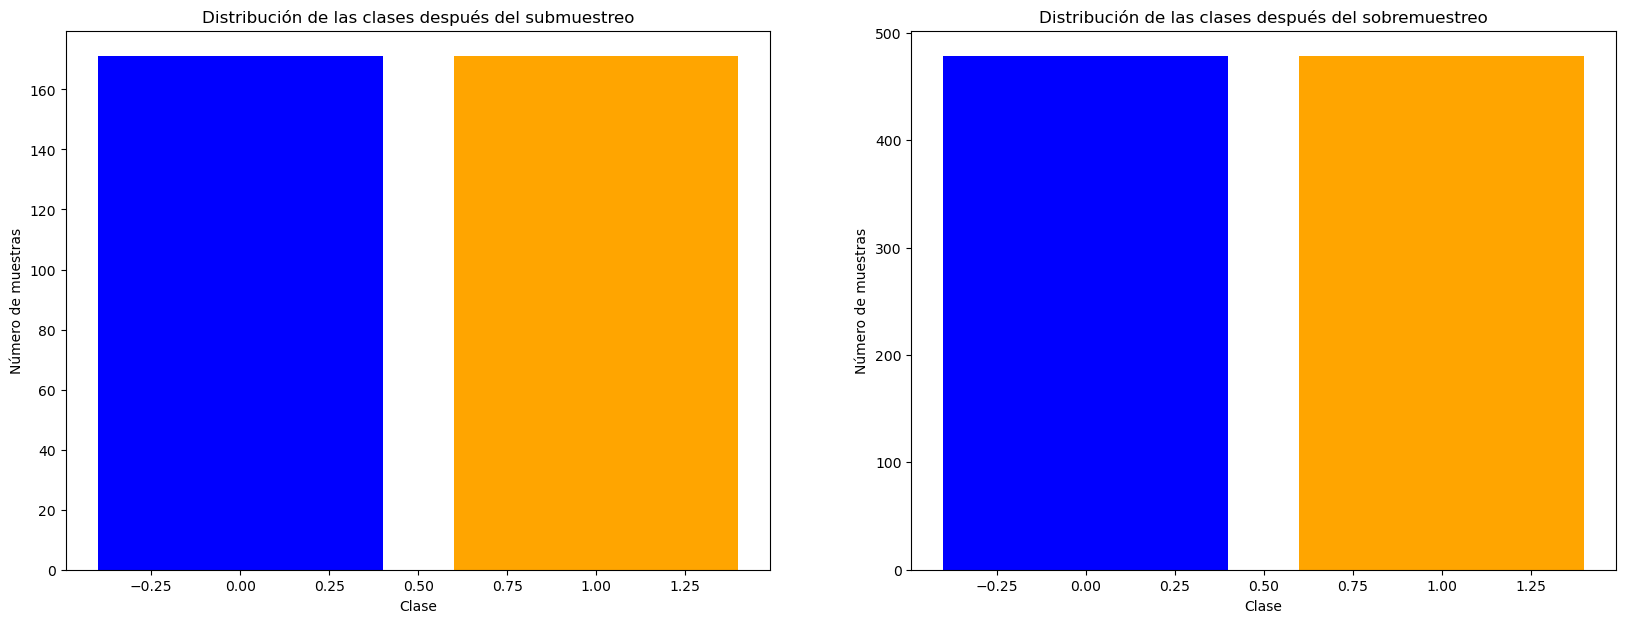

In [689]:
# Contar el número de muestras en cada clase después del submuestreo
under_counts = df_under['Calificacion'].value_counts()

# Contar el número de muestras en cada clase después del sobremuestreo
over_counts = df_over['Calificacion'].value_counts()

# Crear una figura con dos subgráficos
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Gráfico de barras para el submuestreo
ax[0].bar(under_counts.index, under_counts.values, color=['blue', 'orange'])
ax[0].set_title('Distribución de las clases después del submuestreo')
ax[0].set_xlabel('Clase')
ax[0].set_ylabel('Número de muestras')

# Gráfico de barras para el sobremuestreo
ax[1].bar(over_counts.index, over_counts.values, color=['blue', 'orange'])
ax[1].set_title('Distribución de las clases después del sobremuestreo')
ax[1].set_xlabel('Clase')
ax[1].set_ylabel('Número de muestras')

# Mostrar la figura
plt.show()

**df_under**: Este conjunto de datos se ha creado mediante el submuestreo de la clase mayoritaria para igualar el número de muestras de la clase minoritaria. Puedes usar este conjunto de datos si quieres dar igual importancia a todas las clases en tu modelo.

**df_over**: Este conjunto de datos se ha creado mediante el sobremuestreo de la clase minoritaria para igualar el número de muestras de la clase mayoritaria. Puedes usar este conjunto de datos si tu modelo tiene problemas para reconocer la clase minoritaria debido a su escasez de muestras.

Como queremos darle la misma importancia a ambos datos empleamos df_under a menos que se encuentren problemas en el modelo para reconocer los suspensos.

### Particionamiento del dataset en Train-Validation-Test
Particionamos los datos en train,validacion y test por cada atributo target que tenemos, en este caso son 3 'G1','G2' y 'Media_G1_G2'.

Se distingue entre atributos de entrada y de salida. Se usa como atributos de entrada todos a excepcion de los que usamos como salida, que son 'G1','G2','Media_G1_G2','Calificacion', que contiene los atrigutos target de nuestros modelos 'Calidicacion' para los modelos de calsificacion y las notas y la media los modelos de prediccion).

In [690]:
# Hacemos un particionamiento estándar, 60% para train y 40% para test
train_data, temp_data = train_test_split(df_under, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Sacamos los atributos target
y_train_G1 = train_data['G1']
y_train_G2 = train_data['G2']
y_train_media = train_data['Media_G1_G2']


# Definimos X con el resto de atributos que no son los targets
X_train = train_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)

# Definimos los conjuntos de Test
y_test_G1 = test_data['G1']
y_test_G2 = test_data['G2']
y_test_media = test_data['Media_G1_G2']

# Sacamos los atributos de validacion
y_val_G1 = val_data['G1']
y_val_G2 = val_data['G2']
y_val_media = val_data['Media_G1_G2']

# Definimos X con el resto de atributos que no son los targets
X_test = test_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)
X_val = val_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)


y_train_calificacion = train_data['Calificacion']
y_test_calificacion = test_data['Calificacion']
y_val_calificacion = val_data['Calificacion']

In [691]:
# Resumen estadístico de las variables de entrada del conjunto de entrenamiento
X_train.describe()

,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,schoolsup,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,...,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.453659,16.882927,0.663415,0.312195,0.858537,2.443902,2.302439,1.678049,1.785366,0.058537,...,0.531707,0.307317,0.063415,0.478049,0.229268,0.117073,0.175610,0.214634,0.687805,0.097561
std,0.499067,1.270306,0.473698,0.464523,0.349352,1.134583,1.131650,0.782001,0.799988,0.235330,...,0.500215,0.462511,0.244304,0.500741,0.421391,0.322294,0.381419,0.411573,0.464523,0.297446
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,17.000000,1.000000,0.000000,1.000000,2.000000,2.000000,2.000000,2.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,18.000000,1.000000,1.000000,1.000000,4.000000,3.000000,2.000000,2.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,21.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [692]:
# Resumen estadístico de las variables de entrada del conjunto de entrenamiento
X_val.describe()

,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,schoolsup,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,...,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,0.397059,16.882353,0.602941,0.235294,0.911765,2.455882,2.132353,1.632353,1.882353,0.176471,...,0.632353,0.264706,0.014706,0.470588,0.176471,0.161765,0.191176,0.205882,0.705882,0.088235
std,0.492926,1.366217,0.492926,0.427336,0.285746,1.112129,1.170590,0.826870,0.922835,0.384054,...,0.485750,0.444457,0.121268,0.502845,0.384054,0.370973,0.396151,0.407351,0.459033,0.285746
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,17.000000,1.000000,0.000000,1.000000,2.000000,2.000000,1.000000,2.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,18.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,2.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,22.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [693]:
# Resumen estadístico de las variables de entrada del conjunto de entrenamiento
X_test.describe()

,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,schoolsup,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,...,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,0.492754,16.927536,0.695652,0.231884,0.927536,2.347826,2.144928,1.463768,1.840580,0.101449,...,0.594203,0.289855,0.028986,0.463768,0.188406,0.101449,0.246377,0.289855,0.652174,0.057971
std,0.503610,1.167184,0.463502,0.425127,0.261154,1.135342,1.074783,0.698311,0.740095,0.304135,...,0.494643,0.457019,0.168995,0.502339,0.393901,0.304135,0.434057,0.457019,0.479770,0.235401
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,17.000000,1.000000,0.000000,1.000000,2.000000,2.000000,1.000000,2.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,18.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,2.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,19.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


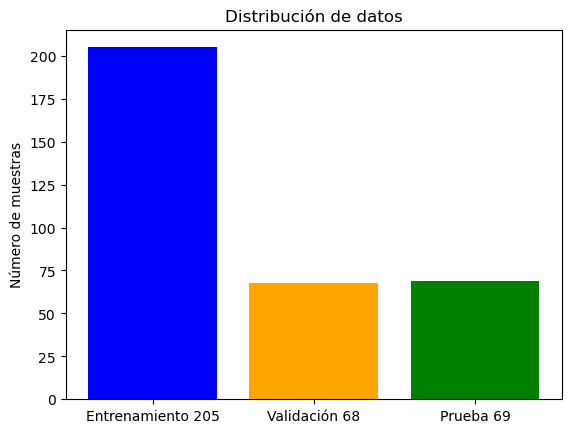

In [694]:
# Número de muestras en cada conjunto de datos
num_train = len(X_train)
num_val = len(X_val)
num_test = len(X_test)

# Etiquetas para el eje x
labels = [f'Entrenamiento {num_train}', f'Validación {num_val}', f'Prueba {num_test}']

# Valores (número de muestras)
values = [num_train, num_val, num_test]

# Crear el histograma
plt.bar(labels, values, color=['blue', 'orange', 'green'])

# Añadir títulos y etiquetas
plt.title('Distribución de datos')
plt.ylabel('Número de muestras')

# Mostrar el gráfico
plt.show()

### Estandarizacion de datos

Los modelos asumen que todas las características están centradas alrededor de cero y tienen la misma varianza. Si una característica tiene una varianza que es órdenes de magnitud mayor que otras, podría dominar la función objetivo y hacer que el estimador no pueda aprender de otras características correctamente como se esperaba. La estandarización hace que los datos cumplan con estos supuestos y puede hacer que el algoritmo de aprendizaje sea más eficiente.

In [695]:
# Creamos el estandarizador
scaler = StandardScaler()

# Ajustamos el estandarizador con los datos de entrenamiento y luego transformamos los datos de entrenamiento
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Regresion Lineal

Al tener como target un atributo numerico nos parecía interesante probar un modelo de prediccion.

In [696]:
# Aplicamos el modelo de regresión lineal
modelo_lineal_G1 = LinearRegression()
modelo_lineal_G2 = LinearRegression()
modelo_lineal_media = LinearRegression()

# Entrenamos el modelo
modelo_lineal_G1.fit(X_train, y_train_G1)
modelo_lineal_G2.fit(X_train, y_train_G2)
modelo_lineal_media.fit(X_train, y_train_media)

# Generamos las predicciones del modelo para los datos de entrenamiento
y_train_pred_G1 = modelo_lineal_G1.predict(X_train)
y_train_pred_G2 = modelo_lineal_G2.predict(X_train)
y_train_pred_media = modelo_lineal_media.predict(X_train)

# Calculamos la salida del modelo
y_pred_G1 = modelo_lineal_G1.predict(X_test)
y_pred_G2 = modelo_lineal_G2.predict(X_test)
y_pred_media = modelo_lineal_media.predict(X_test)

# Medimos el error cuadrático medio del modelo
mse_G1 = mean_squared_error(y_test_G1, y_pred_G1)
mse_G2 = mean_squared_error(y_test_G2, y_pred_G2)
mse_media = mean_squared_error(y_test_media, y_pred_media)

print("MSE para G1 = ", round(mse_G1, 2))
print("MSE para G2 = ", round(mse_G2, 2))
print("MSE para Media = ", round(mse_media, 2))

MSE para G1 =  7.74
MSE para G2 =  11.88
MSE para Media =  9.07


# Regresion Lineal Polinomica (grado: 3)

A continuación probaremos con un modelo polinómico para comprobar si de esta manera conseguimos un mejor resultado.

In [697]:
# Creamos una instancia de LinearRegression
model_G1 = LinearRegression()
model_G2 = LinearRegression()
model_media = LinearRegression()

degree = 3

# Creamos una instancia de PolynomialFeatures para transformar nuestros datos a un espacio polinomial
poly = PolynomialFeatures(degree=degree)

# Transformamos nuestros datos de entrenamiento y de prueba
X_train_poly_G1 = poly.fit_transform(X_train)
X_test_poly_G1 = poly.transform(X_test)

X_train_poly_G2 = poly.fit_transform(X_train)
X_test_poly_G2 = poly.transform(X_test)

X_train_poly_media = poly.fit_transform(X_train)
X_test_poly_media = poly.transform(X_test)

# Entrenamos el modelo
model_G1.fit(X_train_poly_G1, y_train_G1)
model_G2.fit(X_train_poly_G2, y_train_G2)
model_media.fit(X_train_poly_media, y_train_media)

# Hacemos predicciones
y_pred_G1 = model_G1.predict(X_test_poly_G1)
y_pred_G2 = model_G2.predict(X_test_poly_G2)
y_pred_media = model_media.predict(X_test_poly_media)

# Calculamos la precisión del modelo
precision_G1 = accuracy_score(y_test_G1, np.round(y_pred_G1))
precision_G2 = accuracy_score(y_test_G2, np.round(y_pred_G2))
precision_media = accuracy_score(y_test_media, np.round(y_pred_media))

print(f"Grado del polinomio: {degree}")
print("Precision para G1 = ", round(precision_G1*100,2), "%")
print("Precision para G2 = ", round(precision_G2*100,2), "%")
print("Precision para Media = ", round(precision_media*100,2), "%")

Grado del polinomio: 3
Precision para G1 =  14.49 %
Precision para G2 =  20.29 %
Precision para Media =  14.49 %


Los modelos de regresión lineal y polinomial aplicados a los datos de los estudiantes muestran una precisión muy baja. A pesar de que el accuracy ha subido de forma general al aplicar las polinómicas en el modelo el resultado sigue siedo tan bajo que comprenderemos que esta taréa no nos dará buenos resultados con estas técnicas, lo que indica que estos modelos no son adecuados para predecir las calificaciones de los estudiantes.

Esto sugiere que se necesitan enfoques más sofisticados, posiblemente incluyendo otros tipos de modelos o recopilación de más datos.

### Graficamos los datos que hemos calculado

Veremos de manera gráfica los datos comparados con las predicciones y como nuestro modelo se ajusta a estos datos.

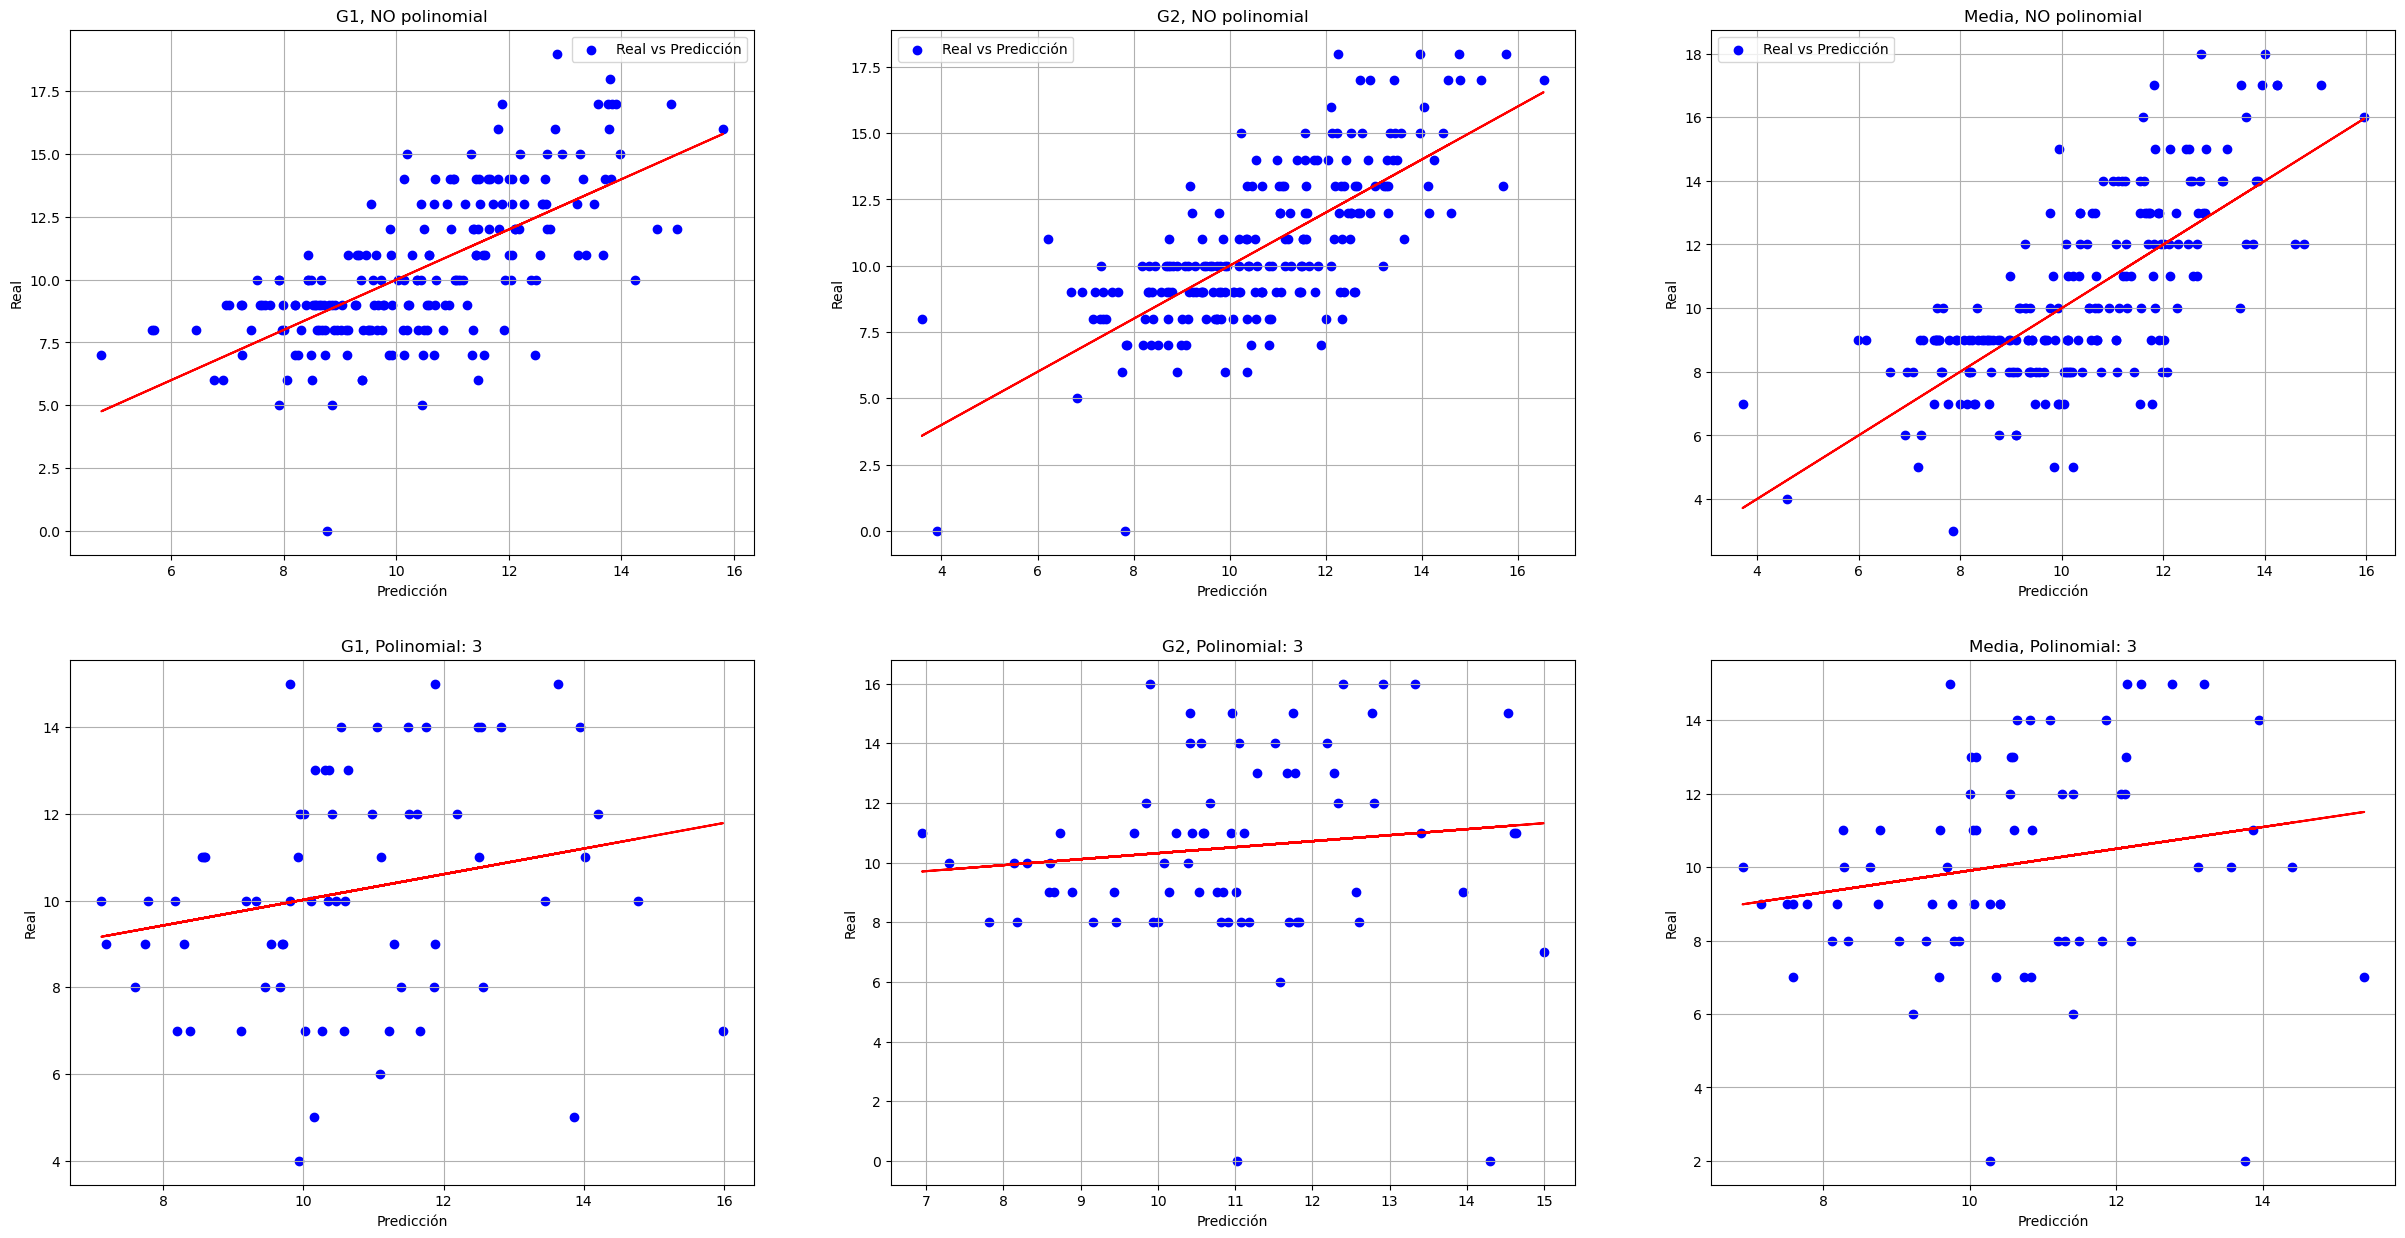

In [698]:
# Creamos una figura y un conjunto de subtramas
fig, ax = plt.subplots(2, 3, figsize=(30, 15))

# Graficamos los datos reales y las predicciones del modelo para G1
ax[0][0].scatter(y_train_pred_G1, y_train_G1, color='blue', label='Real vs Predicción')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_train_pred_G1, y_train_G1, 1)
ax[0][0].plot(y_train_pred_G1, m*y_train_pred_G1 + b, color='red')

ax[0][0].set_title('G1, NO polinomial')
ax[0][0].set_xlabel('Predicción')
ax[0][0].set_ylabel('Real')
ax[0][0].grid(True)
ax[0][0].legend()

# Graficamos los datos reales y las predicciones del modelo para G2
ax[0][1].scatter(y_train_pred_G2, y_train_G2, color='blue', label='Real vs Predicción')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_train_pred_G2, y_train_G2, 1)
ax[0][1].plot(y_train_pred_G2, m*y_train_pred_G2 + b, color='red')

ax[0][1].set_title('G2, NO polinomial')
ax[0][1].set_xlabel('Predicción')
ax[0][1].set_ylabel('Real')
ax[0][1].grid(True)
ax[0][1].legend()

# Graficamos los datos reales y las predicciones del modelo para Media
ax[0][2].scatter(y_train_pred_media, y_train_media, color='blue', label='Real vs Predicción')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_train_pred_media, y_train_media, 1)
ax[0][2].plot(y_train_pred_media, m*y_train_pred_media + b, color='red')

ax[0][2].set_title('Media, NO polinomial')
ax[0][2].set_xlabel('Predicción')
ax[0][2].set_ylabel('Real')
ax[0][2].grid(True)
ax[0][2].legend()

# Graficamos los datos reales y las predicciones del modelo para G1
ax[1][0].scatter(y_pred_G1, y_test_G1, color='blue')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_pred_G1, y_test_G1, 1)
ax[1][0].plot(y_pred_G1, m*y_pred_G1 + b, color='red')

ax[1][0].set_title(f"G1, Polinomial: {degree}")
ax[1][0].set_xlabel('Predicción')
ax[1][0].set_ylabel('Real')
ax[1][0].grid(True)

# Graficamos los datos reales y las predicciones del modelo para G2
ax[1][1].scatter(y_pred_G2, y_test_G2, color='blue')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_pred_G2, y_test_G2, 1)
ax[1][1].plot(y_pred_G2, m*y_pred_G2 + b, color='red')

ax[1][1].set_title(f"G2, Polinomial: {degree}")
ax[1][1].set_xlabel('Predicción')
ax[1][1].set_ylabel('Real')
ax[1][1].grid(True)

# Graficamos los datos reales y las predicciones del modelo para G2
ax[1][2].scatter(y_pred_media, y_test_media, color='blue')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_pred_media, y_test_media, 1)
ax[1][2].plot(y_pred_media, m*y_pred_media + b, color='red')

ax[1][2].set_title(f"Media, Polinomial: {degree}")
ax[1][2].set_xlabel('Predicción')
ax[1][2].set_ylabel('Real')
ax[1][2].grid(True)

# Mostramos la figura
plt.show()

### Conclusiones
Como podemos comprobar se forma una nube de puntos que nos indica que el accuracy de este modelo será muy bajo debido a la diversidad de los datos.

# Regresion Logística

Una vez descartado los modelos de predicción probaremos el modelo mas simple que hemos estudiado de clasificacion, emplearemos como target el atributo que hemos creado para etiquetar los ejemplos 'Calificacion'.

Probaremos tambien distintas maneras de ejecutar este modelo que hemos investigado para encontrar la mejor comfiguración.

In [699]:
# Aplicamos el modelo de regresion logistica
modelo_logistico_calificacion = LogisticRegression()


#Definimos los parametros posibles de nuestro modelo
param_grid = {'C': [0.1, 0.5, 1, 10],              
    'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
    'multi_class': ['ovr', 'multinomial'],
    'penalty': ['l1', 'l2']}

grid_search_log = GridSearchCV(modelo_logistico_calificacion, param_grid, cv=5, scoring='accuracy')

# Ejecutar la búsqueda en el conjunto de datos
grid_search_log.fit(X_train, y_train_calificacion)

# Obtener el mejor modelo y sus parámetros
best_model_log = grid_search_log.best_estimator_
best_params_log = grid_search_log.best_params_


print("Mejores parámetros:", best_params_log)

#Precision Validacion
y_pred_val = best_model_log.predict(X_val)
precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
print("Precision validacion: ", 100 * precision_calificacion_val, "%")

Mejores parámetros: {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
Precision validacion:  67.64705882352942 %


### Estudio de atributos mas significativos

In [700]:
"""# Imprimir los coeficientes del modelo
coef_df = pd.DataFrame(best_model_log.coef_[0], index=Test_names, columns=["Coeficiente"])

# Calcular la importancia de las características
importance = np.abs(best_model_log.coef_[0])

# Crear un DataFrame para visualizar las características y su importancia
importance_df = pd.DataFrame(importance, index=Test_names, columns=["Pesos"])

# Ordenar el DataFrame por importancia
importance_df = importance_df.sort_values(by='Pesos', ascending=False)

print(importance_df)"""

'# Imprimir los coeficientes del modelo\ncoef_df = pd.DataFrame(best_model_log.coef_[0], index=Test_names, columns=["Coeficiente"])\n\n# Calcular la importancia de las características\nimportance = np.abs(best_model_log.coef_[0])\n\n# Crear un DataFrame para visualizar las características y su importancia\nimportance_df = pd.DataFrame(importance, index=Test_names, columns=["Pesos"])\n\n# Ordenar el DataFrame por importancia\nimportance_df = importance_df.sort_values(by=\'Pesos\', ascending=False)\n\nprint(importance_df)'

# Ensembles Adaboost

In [701]:
#Defininos el clasificadores base
clasificador_base = DecisionTreeClassifier(criterion='entropy', max_depth=1)

param_grid = {'n_estimators': list(range(1, 30))}

adaboost = AdaBoostClassifier(base_estimator=clasificador_base)
grid_search_adaboost = GridSearchCV(adaboost, param_grid, cv=5, scoring='accuracy')

# Ejecutar la búsqueda en el conjunto de datos
grid_search_adaboost.fit(X_train, y_train_calificacion)

# Obtener el mejor modelo y sus parámetros
best_model_adaboost = grid_search_adaboost.best_estimator_
best_params_adaboost = grid_search_adaboost.best_params_

print("Mejores parámetros:", best_params_adaboost)

#Precision Validacion
y_pred_val = best_model_adaboost.predict(X_val)
precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
print("Precision validacion: ", 100 * precision_calificacion_val, "%")

Mejores parámetros: {'n_estimators': 9}
Precision validacion:  61.76470588235294 %


Vamos a graficar como evoluciona la precision en el proceso de entrenamiento (utilizando K-Fold) en funcion del numero de estimadores

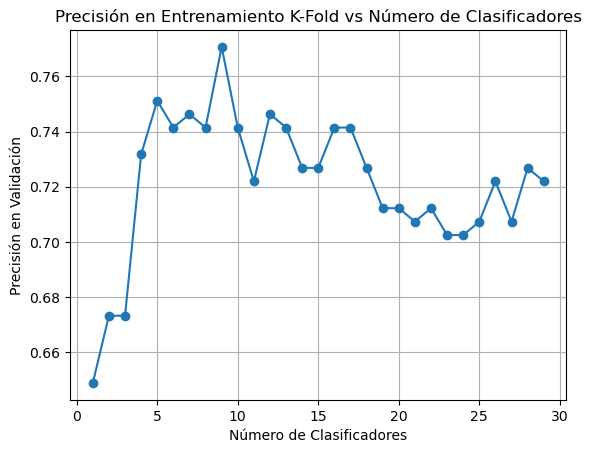

In [702]:

cv_results = grid_search_adaboost.cv_results_
mean_test_scores = cv_results['mean_test_score']

# Crear una lista con el número de estimadores
n_estimators = list(range(1, 30))
plt.plot(n_estimators, mean_test_scores, marker='o')
plt.title('Precisión en Entrenamiento K-Fold vs Número de Clasificadores')
plt.xlabel('Número de Clasificadores')
plt.ylabel('Precisión en Validación')
plt.grid(True)
plt.show()

### Comparacion de PESOS entre modelos

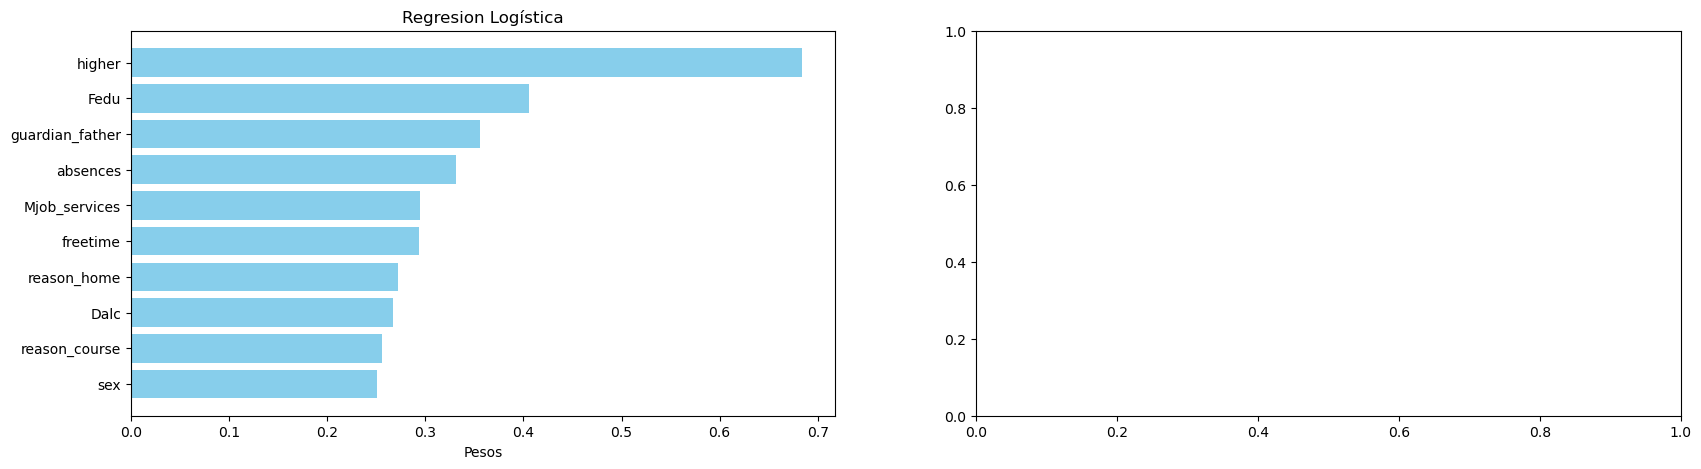

In [703]:
# Crear una figura y un conjunto de ejes
fig, axs = plt.subplots(1,2, figsize=(20, 5))

#REGRESION LOGÍSTICA

# Calcular la importancia de las características
importance = np.abs(best_model_log.coef_[0])

# Ordenar las características por importancia
indices = np.argsort(importance)

# Crear una lista de tuplas (importancia, característica)
importances_features = [(importance[i], Test_names[i]) for i in indices]

# Ordenar la lista de tuplas por importancia
importances_features.sort(reverse=True)

# Obtener las 10 características más importantes
top_features = importances_features[:10]

# Separar las importancias y los nombres de las características
importances = [importance for importance, _ in top_features]
features = [feature for _, feature in top_features]

# Crear un gráfico de barras horizontal
axs[0].barh(features, importances, color='skyblue')

# Invertir el eje y para que las características más importantes aparezcan en la parte superior
axs[0].invert_yaxis()

# Configurar el título y las etiquetas de los ejes
axs[0].set_title('Regresion Logística')
axs[0].set_xlabel('Pesos')

plt.show()

### Red Neuronal

In [704]:
clasificador = MLPClassifier(hidden_layer_sizes= (2*len(X_train[0]), 2) ,max_iter=100)

param_grid = {
    'solver': ['lbfgs', 'sgd', 'adam']
}

grid_search_red = GridSearchCV(clasificador, param_grid, cv=5, scoring='accuracy')


# Ejecutar la búsqueda en el conjunto de datos
grid_search_red.fit(X_train, y_train_calificacion)

# Obtener el mejor modelo y sus parámetros
best_model_red = grid_search_red.best_estimator_
best_params_red = grid_search_red.best_params_

print("Mejores parámetros:", best_params_red)

y_pred_val = best_model_red.predict(X_val)
precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
print("Precision validacion: ", 100 * precision_calificacion_val, "%")


Mejores parámetros: {'solver': 'lbfgs'}
Precision validacion:  61.76470588235294 %


0.5441176470588235


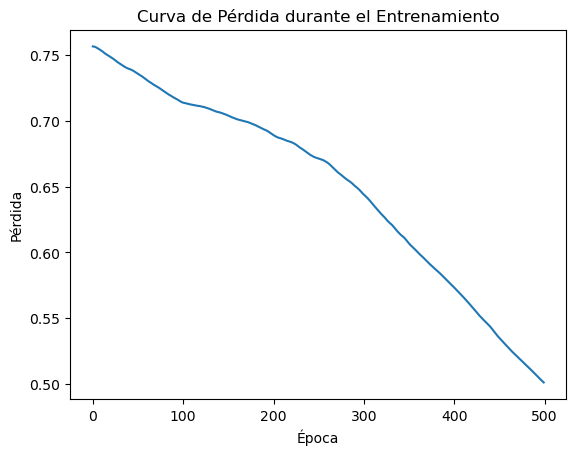

In [705]:
clasificador = MLPClassifier(solver='sgd', hidden_layer_sizes=(2*len(X_train[0]), 2), max_iter=500)
entrenamiento = clasificador.fit(X_train, y_train_calificacion)
y_pred = entrenamiento.predict(X_val)
    
acc_train = accuracy_score(y_pred, y_val_calificacion)


print(acc_train)


plt.plot(clasificador.loss_curve_)
plt.title('Curva de Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

Adaboost 0.6176470588235294
RedNeuronal 0.6176470588235294
RegresionLogistica 0.6764705882352942
El modelo con mayor validacion es:  ('RegresionLogistica', 0.6764705882352942)


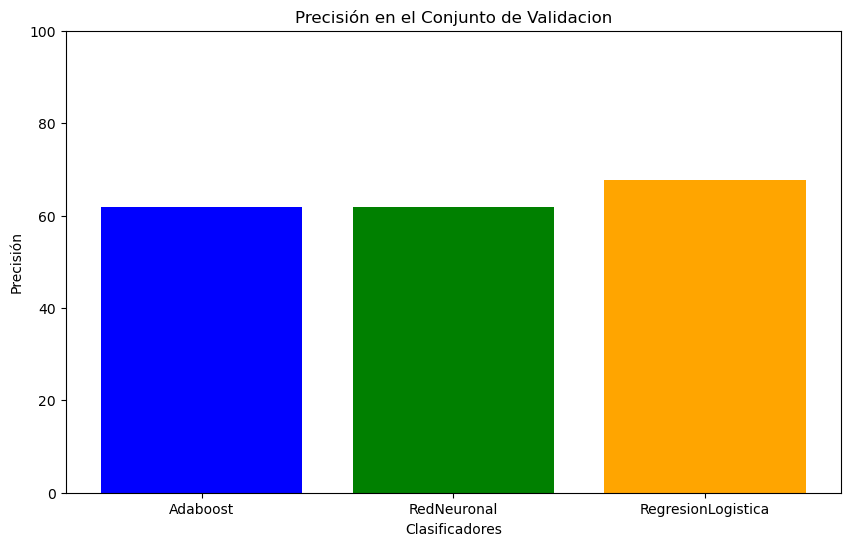

In [706]:
clasificadores_entrenados = [best_model_adaboost, best_model_red, best_model_log]

nombres = ['Adaboost', 'RedNeuronal', 'RegresionLogistica']

# Inicializar precisiones
ganador = (0, 0)
bestPres = 0


precision_val = []

for i, clasificador in enumerate(clasificadores_entrenados):
    #Iteramos en la lista clasificadores y miramos la precision de cada uno en validacion
    y_pred_val = clasificador.predict(X_val)
    accVal = accuracy_score(y_val_calificacion, y_pred_val)
    precision_val.append(100 * accVal)
    print(nombres[i], accVal)
    
    #Guardamos la validacion maxima
    if (accVal > bestPres):
        bestPres = accVal
        ganador = (nombres[i], accVal)
        mejor_clasificador = clasificador


print("El modelo con mayor validacion es: ", ganador)




plt.figure(figsize=(10, 6))
plt.bar(nombres, precision_val, color=['blue', 'green', 'orange'])
plt.title('Precisión en el Conjunto de Validacion')
plt.xlabel('Clasificadores')
plt.ylabel('Precisión')
plt.ylim(0, 100)
plt.show()

Calculamos la precision en test del mejor modelo entrenado

In [707]:
precision_test = []
y_pred_test = mejor_clasificador.predict(X_test)
accTest = accuracy_score(y_test_calificacion, y_pred_test)
print("La prediccion final es: ", accTest)

La prediccion final es:  0.7101449275362319


Adaboost 0.7101449275362319


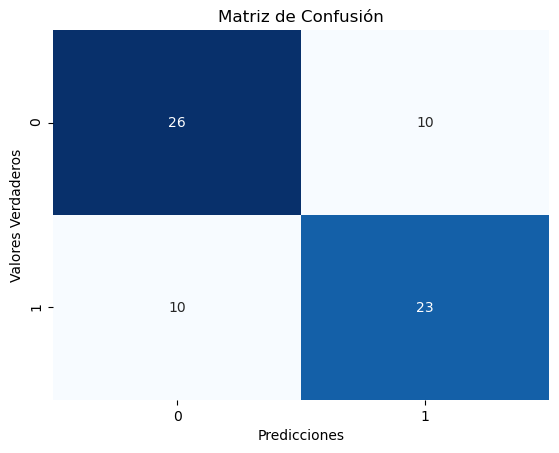

RedNeuronal 0.6811594202898551


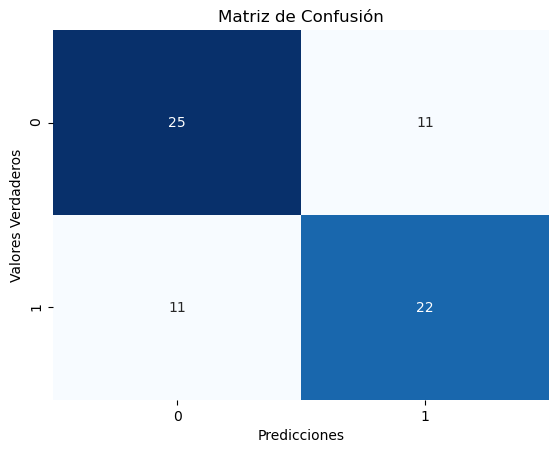

RegresionLogistica 0.7101449275362319


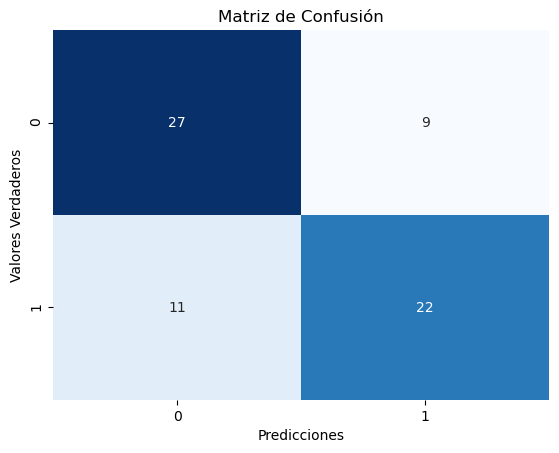

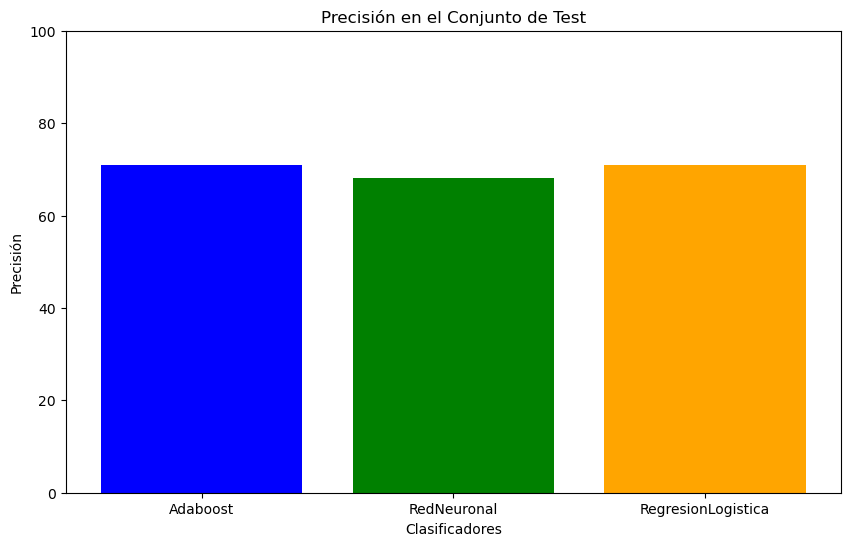

In [708]:
import seaborn as sns
nombres = ['Adaboost', 'RedNeuronal', 'RegresionLogistica']

# Inicializar parametros
ganador = (0, 0)
bestPres = 0
precision_test = []

for i, clasificador in enumerate(clasificadores_entrenados):
    #Iteramos en la lista clasificadores y miramos la precision de cada uno en validacion
    y_pred_test = clasificador.predict(X_test)
    accTest = accuracy_score(y_test_calificacion, y_pred_test)
    precision_test.append(100 * accTest)
    print(nombres[i], accTest)
    matriz_confusion = confusion_matrix(y_test_calificacion, y_pred_test)

    # Imprime la matriz de confusión
    sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test_calificacion), yticklabels=np.unique(y_test_calificacion))

    # Configuraciones adicionales para mejorar la visualización
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Verdaderos')
    plt.show()
    
    #Guardamos la validacion maxima
    if (accTest > bestPres):
        bestPres = accTest
        ganador = (nombres[i], accTest)
        mejor_clasificador = clasificador


plt.figure(figsize=(10, 6))
plt.bar(nombres, precision_test, color=['blue', 'green', 'orange'])
plt.title('Precisión en el Conjunto de Test')
plt.xlabel('Clasificadores')
plt.ylabel('Precisión')
plt.ylim(0, 100)
plt.show()

# K-Means

Como nuestros ejemplos los hemos etiquetado nosotros, creemos que seria interesante probar un modelo de clustering ya que el dataset original no tiene los datos etiquetados y estudiar los clusters resultantes.

Comprobaremos mediante DB estudiado en clase el mejor numero de clusters.

In [709]:
"""# Lee el archivo CSV
df = pd.read_csv('student.csv')

# Selecciona solo las columnas 'G1' y 'G2'
df = df[['G1', 'G2']]

# Divide los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Estandariza los datos de entrenamiento
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Estandariza los datos de prueba
test_data_scaled = scaler.transform(test_data)

# Inicializa la lista para guardar los índices de Davies-Bouldin
db_scores = []

# Prueba diferentes valores de k
for k in range(2, 10):
    # Crea el modelo de K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Ajusta el modelo a los datos de entrenamiento
    kmeans.fit(train_data_scaled)

    # Obtiene las etiquetas de los clusters para los datos de entrenamiento
    train_labels = kmeans.labels_

    # Predice las etiquetas de los clusters para los datos de prueba
    test_labels = kmeans.predict(test_data_scaled)

    # Calcula el índice de Davies-Bouldin para los datos de entrenamiento
    db_score = davies_bouldin_score(train_data_scaled, train_labels)
    
    # Guarda el índice de Davies-Bouldin en la lista
    db_scores.append(db_score)

# Encuentra el valor de k que da el índice de Davies-Bouldin más bajo
best_k = db_scores.index(min(db_scores)) + 2

print("El mejor valor de k es: ", best_k)"""

'# Lee el archivo CSV\ndf = pd.read_csv(\'student.csv\')\n\n# Selecciona solo las columnas \'G1\' y \'G2\'\ndf = df[[\'G1\', \'G2\']]\n\n# Divide los datos en conjuntos de entrenamiento y prueba\ntrain_data, test_data = train_test_split(df, test_size=0.2, random_state=42)\n\n# Estandariza los datos de entrenamiento\nscaler = StandardScaler()\ntrain_data_scaled = scaler.fit_transform(train_data)\n\n# Estandariza los datos de prueba\ntest_data_scaled = scaler.transform(test_data)\n\n# Inicializa la lista para guardar los índices de Davies-Bouldin\ndb_scores = []\n\n# Prueba diferentes valores de k\nfor k in range(2, 10):\n    # Crea el modelo de K-Means\n    kmeans = KMeans(n_clusters=k, random_state=42)\n\n    # Ajusta el modelo a los datos de entrenamiento\n    kmeans.fit(train_data_scaled)\n\n    # Obtiene las etiquetas de los clusters para los datos de entrenamiento\n    train_labels = kmeans.labels_\n\n    # Predice las etiquetas de los clusters para los datos de prueba\n    test_la

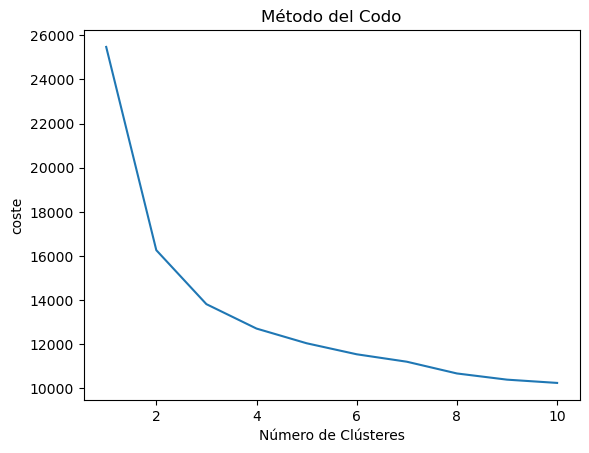

   G1  G2  Calificacion  Cluster
0   0  11             1        2
1   9  11             0        0
2  12  13             0        2
3  14  14             0        0
4  11  13             0        0


In [710]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


df_muestra = df[['Calificacion', 'Media_G1_G2', 'G1', 'G2']]
df = df.drop(['Calificacion', 'Media_G1_G2', 'G1', 'G2'], axis=1)


# Determinar el número óptimo de clústeres utilizando el método del codo
coste = []  # Within-Cluster-Sum-of-Squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    coste.append(kmeans.inertia_)

# Graficar el método del codo
plt.plot(range(1, 11), coste)
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('coste')  # Within-Cluster-Sum-of-Squares
plt.show()

# Elegir el número óptimo de clústeres basado en el gráfico del codo
# En este caso, observa el punto donde la disminución en WCSS se desacelera significativamente
# y selecciona ese número como el número óptimo de clústeres

# Aplicar K-means con el número óptimo de clústeres
optimal_clusters = 3# Ingresa el número óptimo de clústeres
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df)

df_muestra['Cluster'] = kmeans.labels_
print(df_muestra[['G1', 'G2', 'Calificacion', 'Cluster']].head())

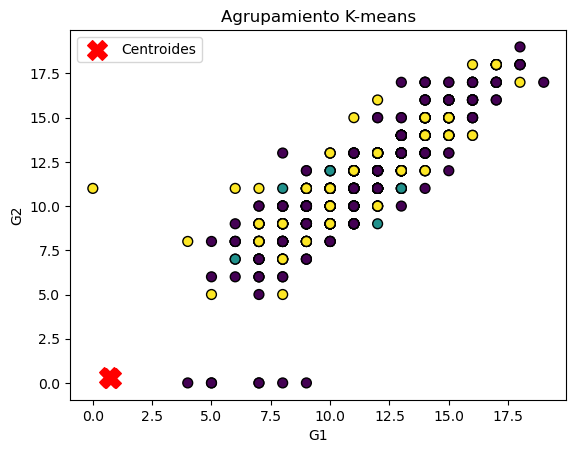

In [711]:
# Visualizar los resultados en un diagrama de dispersión
plt.scatter(df_muestra['G1'], df_muestra['G2'], c=df_muestra['Cluster'], cmap='viridis', edgecolors='k', s=50)
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], s=200, c='red', marker='X', label='Centroides')
plt.title('Agrupamiento K-means')
plt.xlabel('G1')
plt.ylabel('G2')
plt.legend()
plt.show()
